In [1]:
from functools import partial
import jax
import os
import html
import numpy as np

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.envs.original import Pendulum 
from src.envs.realistic import RealisticPendulum 
from src.dyn_model.Predict import pretrained_params




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [3]:
env = Pendulum.Pendulum()
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

In [5]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')
    plt.plot(x_data, y_data)
    plt.show()

# policy_hds = train_hds(env,trajectory_length=100 ,num_samples=100,epochs=20, inner_epochs=20, alpha_a=8e-5, aggregation_factor_beta=0.175,
#                        init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f) 

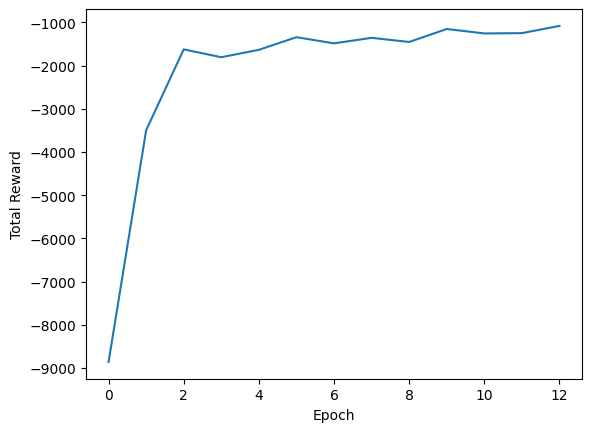

In [6]:
policy_pods = train_pods(env,trajectory_length=100 ,num_samples=50,epochs=30, inner_epochs=20, alpha_a=2e-4, init_learning_rate=1e-3, progress_fn=progress_f)


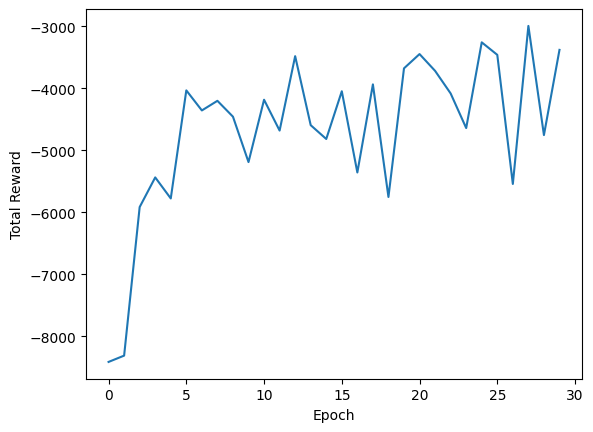

big epoch: 29 small epoch: 0 Loss 5.0238990825903135e-06


In [ ]:
policy_hds = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=30, inner_epochs=20, alpha_a=2e-5, aggregation_factor_beta=0.2, init_learning_rate=1e-3, init_noise=0.0, noise_decay=0.5, progress_fn=progress_f) 

In [ ]:
realistic_env = RealisticPendulum.RealisticPendulum()
# inference_fn_hds = policy_hds()
inference_fn_pods = policy_pods()
inference_fn_hds = policy_hds()

@partial(jax.vmap, in_axes=(None, None, None, 0), axis_name="batch")
def rollout_policy(
        env, inference_fn, trajectory_length: int, prng_keys
    ):

    def step_trajectory(state_carry, rng_key):
        action = inference_fn(state_carry.obs)
        next_state = env.step(state_carry, action)
        return next_state, (state_carry.obs, action, next_state.reward)

    state = env.reset(prng_keys)
    keys = jax.random.split(prng_keys, trajectory_length)
    _, (states, actions, rewards_future) = jax.lax.scan(
        step_trajectory, state, xs=keys
    )

    states = jax.numpy.reshape(
        states, (trajectory_length, env.observation_size)
    )
    actions = jax.numpy.reshape(
        actions, (trajectory_length, env.action_size)
    )

    totalreward = jp.sum(rewards_future)

    return states, actions, totalreward

prng_key = jax.random.PRNGKey(seed=0)
subkeys = jax.random.split(prng_key, num=50)

_, _ , rewards_original_pods  = rollout_policy(env, inference_fn_pods, 100, subkeys)
_, _ , rewards_realistic_pods = rollout_policy(realistic_env, inference_fn_pods, 100, subkeys)
# _, _ , rewards_hds = rollout_policy(realistic_env, inference_fn_hds, 100, subkeys)
# _, _ , rewards_hds_train_env = rollout_policy(env, inference_fn_hds, 100, subkeys)

_, _ , rewards_original_hds  = rollout_policy(env, inference_fn_hds, 100, subkeys)
_, _ , rewards_realistic_hds = rollout_policy(realistic_env, inference_fn_hds, 100, subkeys)

average_reward_original_pods = jp.mean(rewards_original_pods)
average_reward_realistic = jp.mean(rewards_realistic_pods)
average_reward_original_hds = jp.mean(rewards_original_hds)
average_reward_realistic_hds = jp.mean(rewards_realistic_hds)

# average_reward_hds = jp.mean(rewards_hds)
# average_reward_hds_train_env = jp.mean(rewards_hds_train_env)

In [ ]:
print(f'PODS on real environment {jp.mean(jp.array(average_reward_realistic))}')
print(f'PODS on train environment {jp.mean(jp.array(average_reward_original_pods))}')
print(f'HDS on real environment {jp.mean(jp.array(average_reward_realistic_hds))}')
print(f'HDS on train environment {jp.mean(jp.array(average_reward_original_hds))}')
# print(f'HDS on real environment {jp.mean(jp.array(average_reward_hds))}')
# print(f'HDS on train environment {jp.mean(jp.array(average_reward_hds_train_env))}')

PODS on real environment -8156.6986889247855
PODS on train environment -8158.627534114495
HDS on real environment -5134.810685176025
HDS on train environment -2671.638965265071


In [ ]:
# seeds = [x for x in range(100)]
# plt.figure(figsize=(10, 6))
# plt.plot(seeds, rewards_realistic, label='PODS on Real Environment', color='blue')
# plt.plot(seeds, rewards_original_pods, label='PODS on Train Environment', color='red')
# plt.plot(seeds, rewards_hds, label='HDS on Real Environment (Ours)', color='green')
# plt.plot(seeds, rewards_hds_train_env, label='HDS on Train Environment (Ours)', color='orange')
# plt.xlabel('Seed')
# plt.ylabel('Total Reward')
# plt.title('Total Reward across Seeds')
# plt.legend()
# plt.grid(True)
# plt.show()

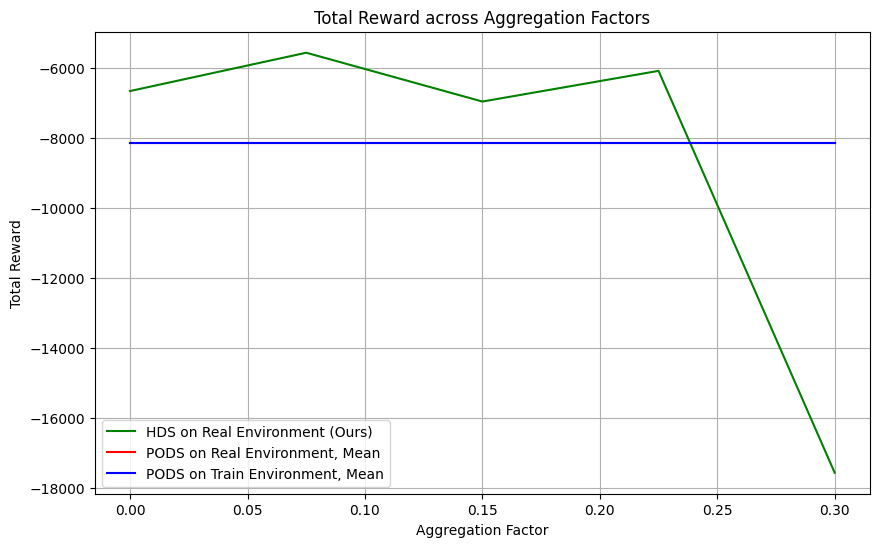

In [ ]:
def run_over_aggregation_factor(aggregation_factor_beta):
    policy = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=20, inner_epochs=20, alpha_a=2e-5, aggregation_factor_beta=aggregation_factor_beta,
                       init_learning_rate=1e-3, init_noise=0.0, noise_decay=0.0, progress_fn=progress_f) 
    inference_fn = policy()
    
    prng_key = jax.random.PRNGKey(seed=0)
    subkeys = jax.random.split(prng_key, num=50)
    _, _ , rewards_hds_real_env  = rollout_policy(realistic_env, inference_fn, 100, subkeys)
    average_reward_hds_real_env = jp.mean(rewards_hds_real_env)
    print(aggregation_factor_beta)
    del policy
    del inference_fn
    return average_reward_hds_real_env

aggregation_factors = np.linspace(0.0,0.3,5)

rewards_dep_aggregation_factor = [run_over_aggregation_factor(x) for x in aggregation_factors]
rewards_pods_real_env = [average_reward_realistic for _ in aggregation_factors]
rewards_pods_train_env = [average_reward_original_pods for _ in aggregation_factors]

plt.figure(figsize=(10, 6))
clear_output(wait=True)
plt.plot(aggregation_factors, rewards_dep_aggregation_factor, label='HDS on Real Environment (Ours)', color='green')
plt.plot(aggregation_factors, rewards_pods_real_env, label='PODS on Real Environment, Mean', color='red')
plt.plot(aggregation_factors, rewards_pods_train_env, label='PODS on Train Environment, Mean', color='blue')
plt.legend()
plt.xlabel('Aggregation Factor')
plt.ylabel('Total Reward')
plt.title('Total Reward across Aggregation Factors')
plt.grid(True)
plt.show()



In [ ]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy_hds()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.47463353]
[0.47463353]
[0.47463353]
[0.47463353]
[0.47463353]
[0.47463353]
[0.47463353]
[0.47463353]
[0.47463353]
[0.47463353]
[0.47463353]
[0.41060844]
[0.35378898]
[0.34095497]
[0.36553116]
[0.41708995]
[0.47463353]
[0.47463353]
[0.47463353]
[0.24034202]
[0.07947516]
[-0.01060171]
[0.00995852]
[0.04740804]
[0.09893023]
[0.15176248]
[0.19079863]
[0.20375269]
[0.21075625]
[0.20684541]
[0.18956]
[0.15638547]
[0.12762791]
[0.10396627]
[0.10877513]
[0.11604516]
[0.13549235]
[0.16112056]
[0.17260999]
[0.15833475]
[0.13361877]
[0.11095191]
[0.08137914]
[0.06177419]
[0.05605351]
[0.05870147]
[0.06215216]
[0.05669059]
[0.04738816]
[0.0455886]
[0.048167]
[0.04841965]
[0.04520322]
[0.04458264]
[0.0451605]
[0.04738099]
[0.05094013]
[0.0557272]
[0.06096222]
[0.06641578]
[0.0717295]
[0.07665288]
[0.07605026]
[0.07361652]
[0.06815829]
[0.06061597]
[0.05143657]
[0.03741409]
[0.02335643]
[0.00450519]
[-0.0223495]
[-0.04324877]
[-0.05779458]
[-0.06123182]
[-0.05587977]
[-0.04220342]
[-0.02329033]
[

In [ ]:

yes=html.render(env.sys.replace(), rollout)
with open("data.html", "w") as file:
    file.write(yes)